In [1]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from accelerate import Accelerator, notebook_launcher
from transformers import AutoModelForSequenceClassification, RobertaForSequenceClassification, AutoTokenizer, get_scheduler, AutoModel
from torch.optim import AdamW
from accelerate.utils import set_seed
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import re

In [2]:
train = pd.read_csv('/kaggle/input/gold-dataset/train_data.csv', sep=',')

In [3]:
test = pd.read_csv('/kaggle/input/gold-dataset/test_data.csv', sep=',')

In [4]:
train.head()

,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,66.50,"Lợi suất trái phiếu toàn cầu đang tăng lên, đi...",24/06/2023,67.10,08:30,Giá vàng hôm nay 24/6: Vọt lên cao rồi cắm đầu...,increase
1,67.65,Tài khoản không đủ để thực hiện chức năng này....,14/07/2022,68.25,09:00,Giá vàng hôm nay 14/7: Vàng trong nước tăng ng...,increase
2,56.75,Giá vàng hôm nay ngày 12/7/2021 biến động từ g...,12/07/2021,57.50,08:55,Giá vàng hôm nay ngày 12/7/2021: biến động nhẹ...,decrease
3,68.20,"Hôm qua, thị trường nhận thông tin về báo cáo ...",05/10/2023,68.90,09:20,Giá vàng hôm nay 5/10: Chuyên gia dự đoán lạc ...,decrease
4,74.30,Giá vàng bật tăng khi căng thẳng quân sự leo t...,30/01/2024,76.80,08:55,"Giá vàng hôm nay 30/1: Nhiều yếu tố hỗ trợ, và...",increase


In [5]:
test.head()

,BID_PRICE,CONTENT,DATE,PRICE,TIME,TITLE,labels
0,67.85,. Sự tin tưởng của khu vực kinh doanh vào một ...,25/06/2022,68.65,09:45,"Giá vàng hôm nay 25/6: ""Hụt hơi"" phiên cuối tu...",decrease
1,82.80,Xu hướng mua ròng vàng miếng của các quốc gia ...,10/04/2024,84.80,08:20,"Giá vàng hôm nay 10/4: Sau ""cơn điên"" tăng giá...",increase
2,66.45,Mặc dù tâm lý lạc quan đã quay trở lại nhưng h...,10/07/2023,67.05,08:30,"Giá vàng hôm nay 10/7: Vàng đi ngang, giới đầu...",decrease
3,56.35,Giá vàng hôm nay ngày 5/1/2021 tăng từ 50.000 ...,05/01/2021,56.90,10:20,Giá vàng hôm nay ngày 5/1/2021: vàng tiếp tục ...,increase
4,68.80,. Giá vàng tiếp đà tăng khi thị trường tài chí...,09/06/2022,69.70,08:30,"Giá vàng hôm nay 9/6: Được hỗ trợ mạnh, vàng p...",increase


In [6]:
def get_config():
    config = {'batch_size': 8,
              'model_name': 'uitnlp/CafeBERT',
              'lr': 10 ** -5,
              'num_labels': 2,
              'epochs': 5,
              'num_warmup_steps': 0,
              'seed': 42, 
              'max_length': 256,
              'eos': '[SEP]'
              
    }
    return config 

In [7]:
config = get_config()

### Preprocessing

In [8]:
def preprocess(text):
    # Loại bỏ các ký tự xuống dòng và thay thế chúng bằng một khoảng trắng
    text = re.sub(r'\r\n+', ' ', text)
    
    # Chuẩn hóa khoảng trắng để không có nhiều khoảng trắng liên tiếp
    text = re.sub(r'\s+', ' ', text)
    
    # Loại bỏ dấu câu
    text = re.sub(r'[^\w\s/]', '', text)
    
    # Thêm dấu chấm câu để tách các câu
    text = re.sub(r'(\d+)([a-zA-Z])', r'\1 \2', text)  # Thêm khoảng trắng giữa số và chữ
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])', ' ', text)   # Thêm khoảng trắng giữa số và chữ nếu không có khoảng trắng
    text = re.sub(r'(?<=[a-zA-Z])(?=\d)', ' ', text)   # Thêm khoảng trắng giữa chữ và số nếu không có khoảng trắng
    text = re.sub(r'(đồng lượng|usdoz|lượng)', r'\1.', text)  # Thêm dấu chấm sau các đơn vị đo lường
    
    # Loại bỏ khoảng trắng thừa ở đầu và cuối chuỗi
    text = text.strip()

    # Chuyển thành chữ thường
    text = text.lower()

    return text

In [9]:
train['TITLE'] = train['TITLE'].apply(lambda x: preprocess(x))
train['CONTENT'] = train['CONTENT'].apply(lambda x: preprocess(x))
test['TITLE'] = test['TITLE'].apply(lambda x: preprocess(x))
test['CONTENT'] = test['CONTENT'].apply(lambda x: preprocess(x))

### Creating dataset

In [10]:
class get_dataset(Dataset):
    def __init__(self, df: pd.DataFrame) -> None:
        super().__init__()
        self.titles = df['TITLE'].values
        self.content = df['CONTENT'].values
        self.labels = df['labels'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = self.titles[idx]
        content = self.content[idx]
        if self.labels[idx] == "increase":
            label = 1
        elif self.labels[idx] == "decrease":
            label = 0
        input_data =title + '[SEP]' + content

        return input_data, label

In [11]:
train_dataset = get_dataset(df=train)
test_dataset  = get_dataset(df=test)

In [12]:
train_dataset[222]

('giá vàng hôm nay 12/9 tăng dè dặt chờ thông tin mới[SEP]giá quý kim bật tăng trong phiên đầu tuần do đồng usd suy yếu tuy nhiên mức tăng này không giữ được lâu thời điểm 8 h 45 sáng nay ngày 12/9 theo giờ việt nam giá vàng thế giới đứng ở mức 1921 usd/ounce giảm nhẹ 1 usd/ounce so với cùng giờ sáng qua giá quý kim bật tăng trong phiên đầu tuần do đồng usd suy yếu tuy nhiên mức tăng này không giữ được lâu vàng quay đầu giảm giá về vùng giá chốt phiên tuần trước thị trường đang chờ đợi dữ liệu lạm phát để có thêm manh mối về hướng đi sắp tới của cục dự trữ liên bang mỹ fed cụ thể báo cáo chỉ số giá tiêu dùng tháng 8 sẽ được công bố vào sáng thứ 4 cpi dự kiến tăng 43 so với cùng kỳ năm trước so với mức tăng 47 trong báo cáo tháng 7 thông tin về cuộc họp chính sách của ngân hàng trung ương châu âu trong tuần này cũng được giới đầu tư quan tâm dự kiến ngân hàng này sẽ tăng nhẹ lãi suất thêm 25 điểm cơ bản nhiều nhà phân tích đã lưu ý rằng vàng đang nằm trong phạm vi giao dịch trung lập do

In [13]:
def create_dataloader(dataset: Dataset, config: dict, is_train: bool) -> DataLoader:

    return DataLoader(dataset=dataset, batch_size=config['batch_size'], shuffle=is_train, drop_last=is_train) 

In [14]:
train_loader = create_dataloader(train_dataset, config, True)
test_loader  = create_dataloader(test_dataset, config, False)

### Training

In [15]:
config['model_name']

'uitnlp/CafeBERT'

In [16]:
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

### Training

In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# create model
model = AutoModelForSequenceClassification.from_pretrained(config['model_name'], num_labels=config['num_labels'])

# create optimizer
optimizer = AdamW(params=model.parameters(), lr=config['lr'])

train_loader = create_dataloader(train_dataset, config, True)
test_loader = create_dataloader(test_dataset, config, False)

num_training_steps = config['epochs'] * len(train_loader)
# create lr scheduler
lr_scheduler = get_scheduler(
    'cosine', optimizer=optimizer, num_warmup_steps=config['num_warmup_steps'], num_training_steps=num_training_steps
)

# create loss function
loss_fn = torch.nn.CrossEntropyLoss()

model.to(device)
epochs = config['epochs']

# Early stopping parameters
patience = 2
best_eval_loss = float('inf')
early_stopping_counter = 0

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at uitnlp/CafeBERT and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# training
print("========== Start training ==========")
for epoch in range(epochs):
    model.train()
    training_loss = 0
    for inputs, labels in train_loader:
        inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
        labels = labels.to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        training_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

    training_loss /= len(train_loader)

    # testing
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
            labels = labels.to(device)

            outputs = model(**inputs, labels=labels)
            loss = outputs.loss
            eval_loss += loss.item()

    eval_loss /= len(test_loader)
    print(f"Epoch {epoch + 1}, Training loss: {training_loss:.4f}, Eval loss: {eval_loss:.4f}")

    # Check for early stopping
    if eval_loss < best_eval_loss:
        best_eval_loss = eval_loss
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered")
        break

print("========== End training ==========")

========== Start training ==========
Epoch 1, Training loss: 0.6015, Eval loss: 0.2148
Epoch 2, Training loss: 0.2372, Eval loss: 0.2207
Epoch 3, Training loss: 0.1380, Eval loss: 0.2165
Early stopping triggered
========== End training ==========


### Inference

In [19]:
preds = []

In [20]:
model.eval()
with torch.no_grad(): 
    for inputs, labels in test_loader:
        inputs = tokenizer(inputs, return_tensors='pt', max_length=config['max_length'], padding='longest', truncation=True).to(device)
        outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        _, predicted_labels = torch.max(probs, dim=1)
        preds.extend(predicted_labels.detach().cpu().tolist()) 

In [21]:
labels = test['labels'].values
labels = [1 if label == 'increase' else 0 for label in labels]

In [22]:
acc  = accuracy_score(labels, preds)
precision = precision_score(labels, preds)
recall = recall_score(labels, preds)
f1 = f1_score(labels, preds)

In [23]:
print(f"========== Evaluation Metrics ==========")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1 Score  : {f1:.4f}")
print(f"========================================")

========== Evaluation Metrics ==========
Accuracy  : 0.9324
Precision : 0.9467
Recall    : 0.9221
F1 Score  : 0.9342


Confusion metrics

Confusion matrix is: [[67  4]
 [ 6 71]]


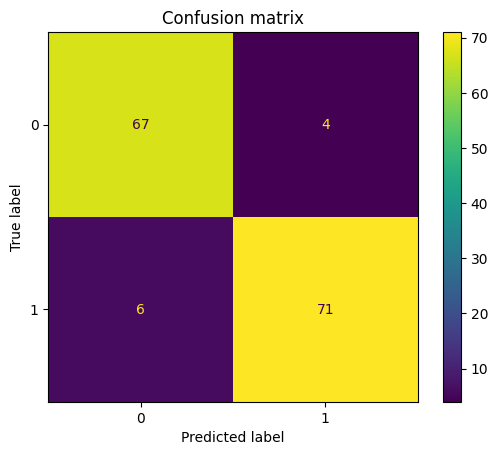

In [24]:
cfn = confusion_matrix(labels, preds)
print(f"Confusion matrix is: {cfn}")
ConfusionMatrixDisplay.from_predictions(labels, preds)
plt.title('Confusion matrix')
plt.show()